# Boxplot of top five up- and downregulated genes

In [1]:
suppressMessages({library(ggpubr)
                  library(tidyverse)
                  library(data.table)})

In [2]:
save_ggplots <- function(p, fn, w=7, h=7){
    for(ext in c('.svg', '.png', '.pdf')){
        ggsave(p, filename=paste0(fn, ext), width=w, height=h)
    }
}


add_symnum <- function(res){
    symnum.args <- list(cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05,  1),
                        symbols = c("****", "***", "**", "*",  "ns"))
    symnum.args$x <- res$adj.P.Val
    pvalue.signif <- do.call(stats::symnum, symnum.args) %>%
        as.character()
    pvalue.format <- format.pval(res$adj.P.Val, digits = 2)
    res <- res %>%
        dplyr::ungroup() %>%
        mutate(FDR = pvalue.format, p.signif = pvalue.signif)
    return(res)
}


## Select most significant DEGs, up- and downregulated

In [3]:
genes = fread('../../metrics_summary/_m/male_specific_DE_genes.txt') %>%
    filter(Type == 'gene') %>% add_symnum()
up_genes = genes %>% filter(t > 0) %>% mutate('Direction'='Upregulated') %>% head(5)
down_genes = genes %>% filter(t < 0) %>% mutate('Direction'='Downregulated') %>% head(5)
sig_genes = bind_rows(up_genes, down_genes) %>% mutate_at(vars(Direction), as.factor)

for(xx in seq_along(sig_genes$Symbol)){
    sig_genes$New_ID[xx] <- ifelse(sig_genes$Symbol[xx] == '', 
                                   as.character(sig_genes$ensemblID[xx]), 
                                   as.character(sig_genes$Symbol[xx]))
}
sig_genes

Feature,gencodeID,Symbol,ensemblID,Chrom,logFC,t,adj.P.Val,Female_Pval,Female_FDR,Type,FDR,p.signif,Direction,New_ID
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<fct>,<chr>
ENSG00000119411.10,ENSG00000119411.10,BSPRY,ENSG00000119411,chr9,0.2801104,5.861029,2.804273e-05,0.43903003,0.45420948,gene,2.8e-05,****,Upregulated,BSPRY
ENSG00000159871.14,ENSG00000159871.14,LYPD5,ENSG00000159871,chr19,0.2138222,5.885126,2.804273e-05,0.36253657,0.39182446,gene,2.8e-05,****,Upregulated,LYPD5
ENSG00000163833.7,ENSG00000163833.7,FBXO40,ENSG00000163833,chr3,0.2534456,5.285296,2.187262e-04,0.23253509,0.26893661,gene,0.00022,***,Upregulated,FBXO40
ENSG00000158457.5,ENSG00000158457.5,TSPAN33,ENSG00000158457,chr7,0.1678253,4.670299,1.520197e-03,0.21443187,0.25255637,gene,0.00152,**,Upregulated,TSPAN33
ENSG00000146360.8,ENSG00000146360.8,GPR6,ENSG00000146360,chr6,0.3438692,4.407612,2.778752e-03,0.32174946,0.35285419,gene,0.00278,**,Upregulated,GPR6
ENSG00000231752.5,ENSG00000231752.5,EMBP1,ENSG00000231752,chr1,-0.1894263,-5.536119,8.324115e-05,0.08502851,0.11691420,gene,8.3e-05,****,Downregulated,EMBP1
ENSG00000164649.19,ENSG00000164649.19,CDCA7L,ENSG00000164649,chr7,-0.2066995,-4.649220,1.644671e-03,0.16622500,0.20570343,gene,0.00164,**,Downregulated,CDCA7L
ENSG00000163347.5,ENSG00000163347.5,CLDN1,ENSG00000163347,chr3,-0.2657650,-4.511176,2.151185e-03,0.12408190,0.15912057,gene,0.00215,**,Downregulated,CLDN1
ENSG00000128606.12,ENSG00000128606.12,LRRC17,ENSG00000128606,chr7,-0.2682977,-4.492311,2.282210e-03,0.31454186,0.34754067,gene,0.00228,**,Downregulated,LRRC17


## Load phenotypes

In [4]:
pheno_file = paste0('/ceph/users/jbenja13/projects/sex_sz_ria/',
                    'input/commonMind/phenotypes/combine_files/',
                    '_m/CMC_phenotypes_all.csv')
pheno = fread(pheno_file) %>% 
    filter(Sex %in% c("XX", "XY"), 
           Dx %in% c("Control", "SCZ")) %>%
    mutate_if(is.character, as.factor) %>%
    select(c(Individual_ID, "RNAseq:Sample_RNA_ID", Dx, Sex))
colnames(pheno)[2] <- "SampleID"
levels(pheno$Sex) <- c("Female", "Male")
levels(pheno$Dx) <- c("CTL", "SZ")
pheno %>% head(2)

Individual_ID,SampleID,Dx,Sex
<fct>,<fct>,<fct>,<fct>
CMC_HBCC_003,CMC_HBCC_RNA_PFC_3158,CTL,Male
CMC_HBCC_005,CMC_HBCC_RNA_PFC_3152,CTL,Male


## Load residualized expression

In [5]:
res_file = '../../../../../interaction_sex_sz/cmc_dlpfc/_m/genes/residualized_expression.tsv'
resdf0 = fread(res_file) %>% 
    filter(V1 %in% sig_genes$gencodeID) %>% 
    column_to_rownames(var="V1") %>% t %>% 
    as.data.frame %>% rownames_to_column() %>% 
    rename(SampleID=rowname) %>% 
    mutate_at("SampleID", as.factor)
resdf0[1:2, 1:5]

Warning message in fread(res_file):
“Detected 858 column names but the data has 859 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”


,SampleID,ENSG00000119411.10,ENSG00000128606.12,ENSG00000146360.8,ENSG00000158457.5
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,MSSM_RNA_PFC_1,-1.2509392,-0.1458972,-0.5281311,0.5226164
2,MSSM_RNA_PFC_2,0.6018737,-1.0077370,0.9476006,-0.5646651


### Merge and melt dataframe

In [6]:
df <- inner_join(pheno, resdf0, by="SampleID") %>%
    select(c('SampleID', 'Sex', 'Dx', starts_with('ENSG'))) %>% 
    pivot_longer(-c(SampleID, Sex, Dx), 
                 names_to='gencodeID', values_to="Res") %>% 
    inner_join(sig_genes, by='gencodeID') %>% 
    mutate_at(vars("New_ID", "Symbol", "gencodeID"), as.factor)
df$New_ID = with(df, reorder(New_ID, adj.P.Val, median))
df$Dx <- fct_drop(df$Dx)
dim(df)
df[1:2, 1:10]

[1] 8580   19

SampleID,Sex,Dx,gencodeID,Res,Feature,Symbol,ensemblID,Chrom,logFC
<fct>,<fct>,<fct>,<fct>,<dbl>,<chr>,<fct>,<chr>,<chr>,<dbl>
CMC_HBCC_RNA_PFC_3158,Male,CTL,ENSG00000119411.10,-0.4446609,ENSG00000119411.10,BSPRY,ENSG00000119411,chr9,0.2801104
CMC_HBCC_RNA_PFC_3158,Male,CTL,ENSG00000128606.12,-0.8120611,ENSG00000128606.12,LRRC17,ENSG00000128606,chr7,-0.2682977


### Initial ggplot with ggpubr

Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”


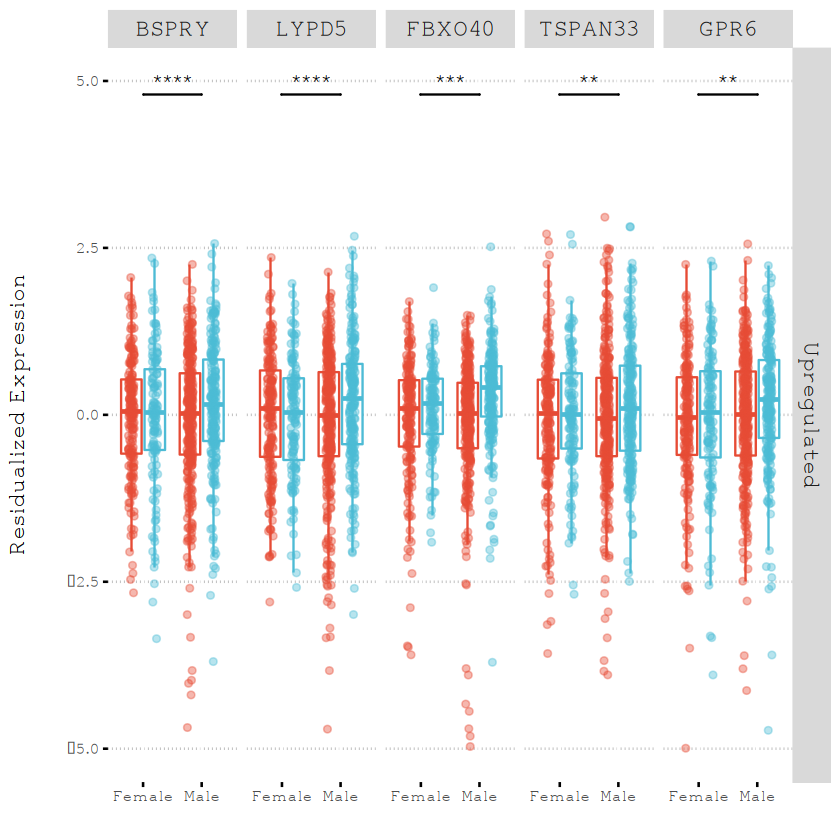

In [7]:
tmp = sig_genes %>% 
    mutate(group1='Female', group2='Male', y_pos=4.8) %>% 
    filter(Direction == 'Upregulated') %>%
    mutate_if(is.character, as.factor)

bxp_up <- df %>% filter(Direction=="Upregulated") %>%
        ggboxplot(x="Sex", y="Res", facet.by=c("Direction", "New_ID"), 
                  add='jitter', color="Dx", xlab='', palette="npg", 
                  panel.labs.font=list(face='bold', size = 14), 
                  ylab='Residualized Expression', ylim=c(-5, 5),
                  add.params=list(alpha=0.4), legend="", 
                  ggtheme=theme_pubclean(), outlier.shape=NA) +
         geom_signif(data=tmp, tip_length = 0,
                     aes(xmin=group1, xmax=group2, annotations=p.signif, y_position = y_pos), 
                     manual=TRUE) + 
         font("xy.title", size=14, face="bold") + font("legend.title", size=16, face="bold") + 
         font("legend.text", size=16)
         
bxp_up

Warning message:
“Ignoring unknown aesthetics: xmin, xmax, annotations, y_position”


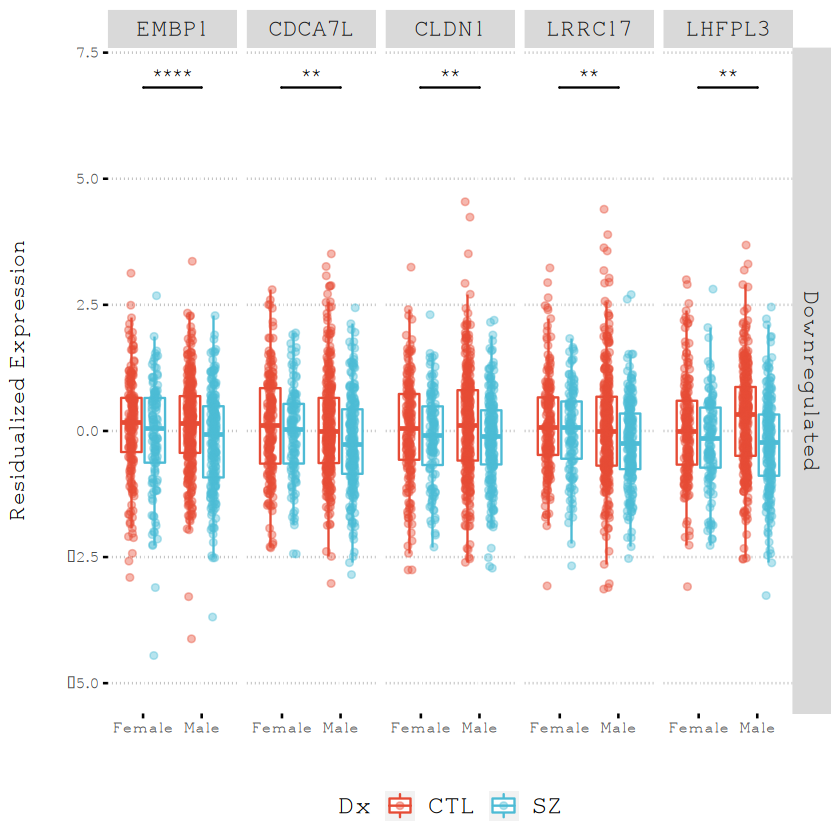

In [8]:
tmp = sig_genes %>% 
    mutate(group1='Female', group2='Male', y_pos=6.8) %>% 
    filter(Direction == 'Downregulated') %>%
    mutate_if(is.character, as.factor)

bxp_down <- df %>% filter(Direction=="Downregulated") %>%
        ggboxplot(x="Sex", y="Res", facet.by=c("Direction", "New_ID"), 
                  add='jitter', color="Dx", xlab='', palette="npg", 
                  panel.labs.font=list(face='bold', size = 14), 
                  ylab='Residualized Expression', ylim=c(-5, 7),
                  add.params=list(alpha=0.4), legend="bottom", 
                  ggtheme=theme_pubclean(), outlier.shape=NA) +
         geom_signif(data=tmp, tip_length = 0,
                     aes(xmin=group1, xmax=group2, annotations=p.signif, y_position = y_pos), 
                     manual=TRUE) + 
         font("xy.title", size=14, face="bold") + font("legend.title", size=16, face="bold") + 
         font("legend.text", size=16)
         
bxp_down

### Annotate figure

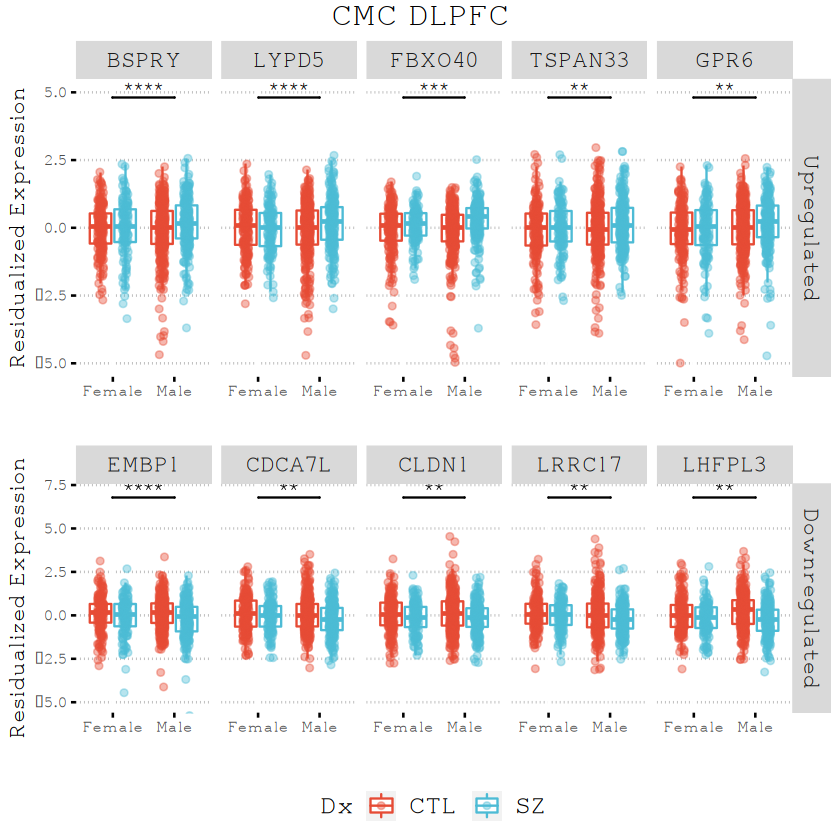

In [9]:
figure <- ggarrange(bxp_up, bxp_down, ncol = 1, nrow = 2)
figure <- annotate_figure(figure, top=text_grob("CMC DLPFC", size=20, face='bold'))
figure

In [10]:
save_ggplots(figure, 'maleSpecific_SZ', 12, 10)

## Session Info

In [11]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()

[1] "2020-12-10 15:08:11 EST"

   user  system elapsed 
 10.857   0.387  13.460 

─ Session info ───────────────────────────────────────────────────────────────────────────────────────────────────────
 setting  value                       
 version  R version 4.0.2 (2020-06-22)
 os       Arch Linux                  
 system   x86_64, linux-gnu           
 ui       X11                         
 language (EN)                        
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       America/New_York            
 date     2020-12-10                  

─ Packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────
 package     * version  date       lib source        
 abind         1.4-5    2016-07-21 [1] CRAN (R 4.0.2)
 assertthat    0.2.1    2019-03-21 [1] CRAN (R 4.0.2)
 backports     1.2.0    2020-11-02 [1] CRAN (R 4.0.2)
 base64enc     0.1-3    2015-07-28 [1] CRAN (R 4.0.2)
 broom         0.7.2    2020-10-20 [1] CRAN (R 4.0.2)
 Cairo         1.5-12.2 2020-07-07 [1] CRAN (R 